In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd/content/drive/MyDrive/HW3

/content/drive/MyDrive/HW3


In [4]:
data_path = 'exchange_rate.txt'

with open(data_path, 'r') as file:
    lines = file.readlines()

# Split each line into individual exchange rates
data = [line.strip().split(',') for line in lines]

# Create a DataFrame
df = pd.DataFrame(data)

# Assign column names
column_names = ['Australia', 'British', 'Canada', 'Switzerland', 'China', 'Japan', 'New Zealand', 'Singapore']
df.columns = column_names

# Optionally, convert exchange rates to numeric values
df = df.astype(float)

# Print the first few rows of the DataFrame
print(df.head())

   Australia  British    Canada  Switzerland     China     Japan  New Zealand  \
0     0.7855   1.6110  0.861698     0.634196  0.211242  0.006838       0.5930   
1     0.7818   1.6100  0.861104     0.633513  0.211242  0.006863       0.5940   
2     0.7867   1.6293  0.861030     0.648508  0.211242  0.006975       0.5973   
3     0.7860   1.6370  0.862069     0.650618  0.211242  0.006953       0.5970   
4     0.7849   1.6530  0.861995     0.656254  0.211242  0.006940       0.5985   

   Singapore  
0   0.525486  
1   0.523972  
2   0.526316  
3   0.523834  
4   0.527426  


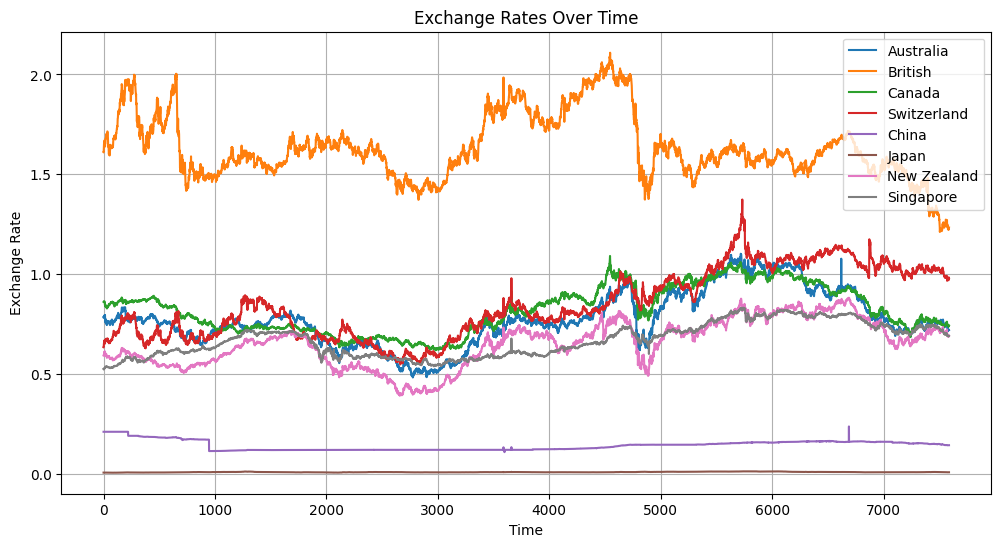

In [5]:
# Plotting the exchange rates over time
plt.figure(figsize=(12, 6))

# Plot each currency exchange rate
for currency in df.columns:
    plt.plot(df.index, df[currency], label=currency)

plt.title('Exchange Rates Over Time')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

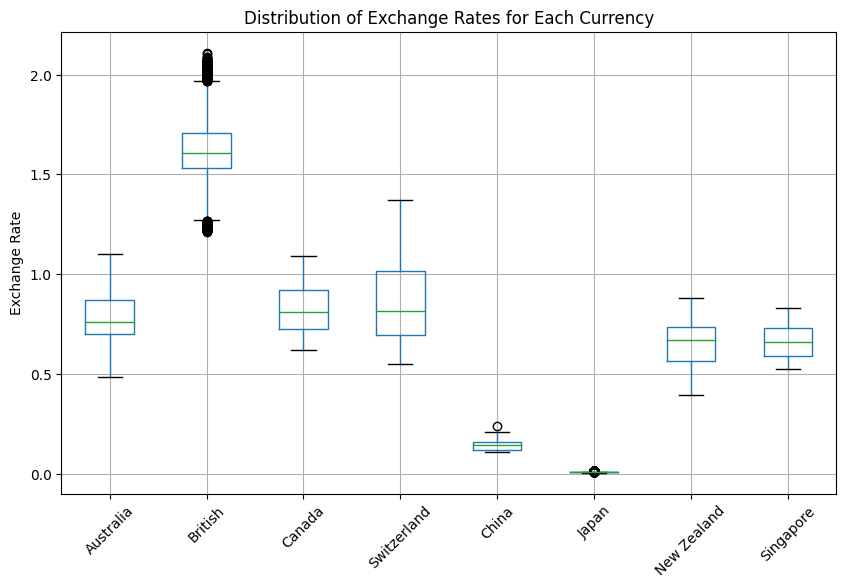

In [6]:
# Box plot of exchange rates for each currency
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Distribution of Exchange Rates for Each Currency')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Get the size of the dataset
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 7588
Number of columns: 8


In [8]:
# Define custom dataset class
class ExchangeRateDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - (self.input_len + self.output_len) + 1

    def __getitem__(self, idx):
        idx_end = idx + self.input_len
        input_seq = self.data[idx:idx_end]
        output_seq = self.data[idx_end:idx_end+self.output_len]
        return input_seq, output_seq

In [9]:
# Create DataLoader for train and test sets
input_dim = 10  # Lookback time series length
output_dim = 1  # Predicted length
batch_size = 64
data = df.values
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

train_dataset = ExchangeRateDataset(train_data, input_dim, output_dim)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ExchangeRateDataset(test_data, input_dim, output_dim)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Transformer

### Attention

In [45]:
class SelfAttentionHead(nn.Module):
    def __init__(self, n_embd,head_size):
        super().__init__()
        self.head_size=head_size

        self.key=nn.Linear(n_embd,n_embd,bias=False)
        self.value=nn.Linear(n_embd,n_embd,bias=False)
        self.query=nn.Linear(n_embd,n_embd,bias=False)

    def forward(self,x,enc_x=None,Mask=False):
        if enc_x is not None:
            key=self.key(enc_x)
            query=self.query(enc_x)
        else:
            key=self.key(x)
            query=self.query(x)


        value=self.value(x)

        attn_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_size ** 0.5)

        seq_length = x.size(1)
        if Mask :
            mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))


        attn_weights = torch.softmax(attn_scores, dim=-1)
        out = torch.matmul(attn_weights, value)
        return out
################################################################################
class MultiHeadSelfAttention(nn.Module):

    def __init__(self,num_heads,n_embd,head_size):
        super().__init__()

        self.heads =nn.ModuleList([SelfAttentionHead(n_embd, head_size) for _ in range(num_heads)])
        self.projection =nn.Linear(num_heads * head_size, n_embd)

    def forward(self,x,enc_x=None,Mask=False):

        attn_outputs = [head(x,enc_x,Mask) for head in self.heads]
        combined_attn = torch.cat(attn_outputs, dim=-1)
        out = self.projection(combined_attn)
        return out
################################################################################
class FeedForward(nn.Module):

    def __init__(self,n_embd,forward_expansion=4):
        super().__init__()

        self.linear=nn.Sequential(nn.Linear(n_embd,n_embd*forward_expansion), nn.ReLU(), nn.Linear(n_embd*forward_expansion,n_embd))


    def forward(self,x):
        out=self.linear(x)
        return out

###Encoder

In [46]:
class EncoderBlock(nn.Module):
    def __init__(self,n_embd,n_head,forward_expansion=4):
        super().__init__()
        self.self_attention =MultiHeadSelfAttention(n_head, n_embd, head_size=8)
        self.feed_forward=FeedForward(n_embd,forward_expansion)
        self.norm1=nn.LayerNorm(n_embd)
        self.norm2=nn.LayerNorm(n_embd)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):

        atten=self.self_attention(x)
        x=self.dropout(self.norm1(x+atten))
        forward=self.feed_forward(x)
        output=self.dropout(self.norm2(forward+x))
        return output
################################################################################
class Encoder(nn.Module):
    def __init__(self,vocab_size,block_size,n_head,n_embd,n_layer):
        super().__init__()

        # self.token_embeding=nn.Embedding(vocab_size, n_embd)
        self.position_embeding=nn.Embedding(block_size, n_embd)
        self.blocks =nn.Sequential(*[EncoderBlock(n_embd, n_head) for _ in range(n_layer)])
        self.dropout=nn.Dropout(0.3)
        # self.conv=nn.Conv1d(9,1,1,1)
    def forward(self,x):

        # token_embeds = self.token_embeding(x)
        seq_length = x.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device)
        position_embeds = self.position_embeding(position_ids)
        # embeddings = token_embeds + position_embeds
        embeddings = x + position_embeds
        out=self.blocks(embeddings)
        # print(out.shape)
        # out=self.conv(out)
        return out

###Decoder

In [47]:
class  DecoderBlock(nn.Module):
    def __init__(self,num_heads,n_embd,head_size,forward_expansion):
        super().__init__()

        self.attention1=MultiHeadSelfAttention(num_heads,n_embd,head_size)
        self.norm1=nn.LayerNorm(n_embd)
        self.attention2=MultiHeadSelfAttention(num_heads,n_embd,head_size)
        self.norm2=nn.LayerNorm(n_embd)
        self.feed_forward=FeedForward(n_embd,forward_expansion=4)
        self.norm3=nn.LayerNorm(n_embd)
        self.dropout=nn.Dropout(0.3)

    def forward(self,x,enc_x):

        att1=self.attention1(x,Mask=True)
        x=self.dropout(self.norm1(x+att1))
        att2=self.attention2(x,enc_x)
        x=self.dropout(self.norm2(x+att2))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))

        return out
################################################################################
class  Decoder(nn.Module):
    def __init__(self,trg_vocab_size,n_embd,max_length,n_head,n_layer,head_size,forward_expansion):
        super().__init__()

        # self.word_embedding = nn.Embedding(trg_vocab_size, n_embd)
        self.position_embedding = nn.Embedding(max_length, n_embd)
        self.blocks = nn.ModuleList([DecoderBlock(n_embd, n_head, head_size, forward_expansion) for _ in range(n_layer)])
        self.f_c=nn.Linear(n_embd,trg_vocab_size)
    def forward(self,x,enc_x):

        # token_embeds = self.token_embeddings(x)

        seq_length = x.size(1)
        position_ids = torch.arange(seq_length, device=x.device)
        position_embeds = self.position_embedding(position_ids)
        # embeddings = token_embeds + position_embeds
        x = x + position_embeds
        for block in self.blocks:
            x=block(x,enc_x)
        # x=self.blocks(x,enc_x)
        out=self.f_c(x)
        return out

### Transformer

In [48]:
# Define custom Transformer model
class TransformerModel(nn.Module):
    def __init__(self,src_vocab_size,trg_vocab_size,block_size=10,n_head=8,n_embd=8,n_layer=6,max_length=10,head_size=8,forward_expansion=4 ):
        super(TransformerModel, self).__init__()

        self.encoder=Encoder(src_vocab_size,block_size,n_head,n_embd,n_layer)
        self.decoder=Decoder(trg_vocab_size,n_embd,max_length,n_head,n_layer,head_size,forward_expansion)


    def forward(self,x_encode,x_decode):
        out=self.encoder(x_encode)
        out=self.decoder(x_decode,out)
        return out



device='cuda' if torch.cuda.is_available() else 'cpu'
lr=1e-3
src_vocab_size = 10
trg_vocab_size = 1
model = TransformerModel(src_vocab_size,trg_vocab_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [43]:
x=torch.rand(64,10,8).to(device)
model(x,x).shape

torch.Size([64, 10, 1])

### Training the Tansformer Model

In [49]:

from tqdm.notebook import tqdm
for epoch in range(25):
    running_loss = 0.0
    for batch in tqdm(train_loader,leave=False):

        inputs,targets  = batch
        inputs = inputs.float().to(device)
        targets=targets.float().to(device)

        #target.shape= (64,1,8)
        #inputs = inputs.view(64*8, 10)


        optimizer.zero_grad()


        outputs = model(inputs,inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()


        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 1, Loss: 0.35578385748361285


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 2, Loss: 0.24598974820814634


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 3, Loss: 0.2382247240919816


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 4, Loss: 0.23520218667231108


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 5, Loss: 0.2336163934908415


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 6, Loss: 0.23259832262992858


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 7, Loss: 0.23188933510529366


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 8, Loss: 0.23139544207798807


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 9, Loss: 0.23110232572806508


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 10, Loss: 0.23098378118715787


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 11, Loss: 0.23087876454779976


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 12, Loss: 0.2307767080633264


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 13, Loss: 0.23069493002013156


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 14, Loss: 0.2306554624908849


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 15, Loss: 0.23064413964748381


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 16, Loss: 0.23062725020082372


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 17, Loss: 0.23061264800397974


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 18, Loss: 0.2306518576647106


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 19, Loss: 0.23060644112135234


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 20, Loss: 0.2305766041341581


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 21, Loss: 0.23057266834535098


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 22, Loss: 0.23060789547468485


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 23, Loss: 0.23060242094491656


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 24, Loss: 0.23052068446811877


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 25, Loss: 0.23055439356126284


In [53]:

mea=nn.L1Loss().to(device)
with torch.no_grad():
    mse_loss=0
    mae_loss=0
    for batch in tqdm(test_loader):
        input,target=batch
        # print(input.shape)
        input ,target=input.float().to(device),target.float().to(device)
        outputs = model(input,input)
        mse_loss+=criterion(outputs,target).item()
        mae_loss+=mea(outputs,target).item()


print(f"On Test data ; MSE: {mse_loss/len(test_loader):.4f} and MAE: {mae_loss/len(test_loader):.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

On Test data ; MSE: 0.2120 and MAE: 0.3684


# ITransformer

ITransformer has only encoder (no decoder) in its structure

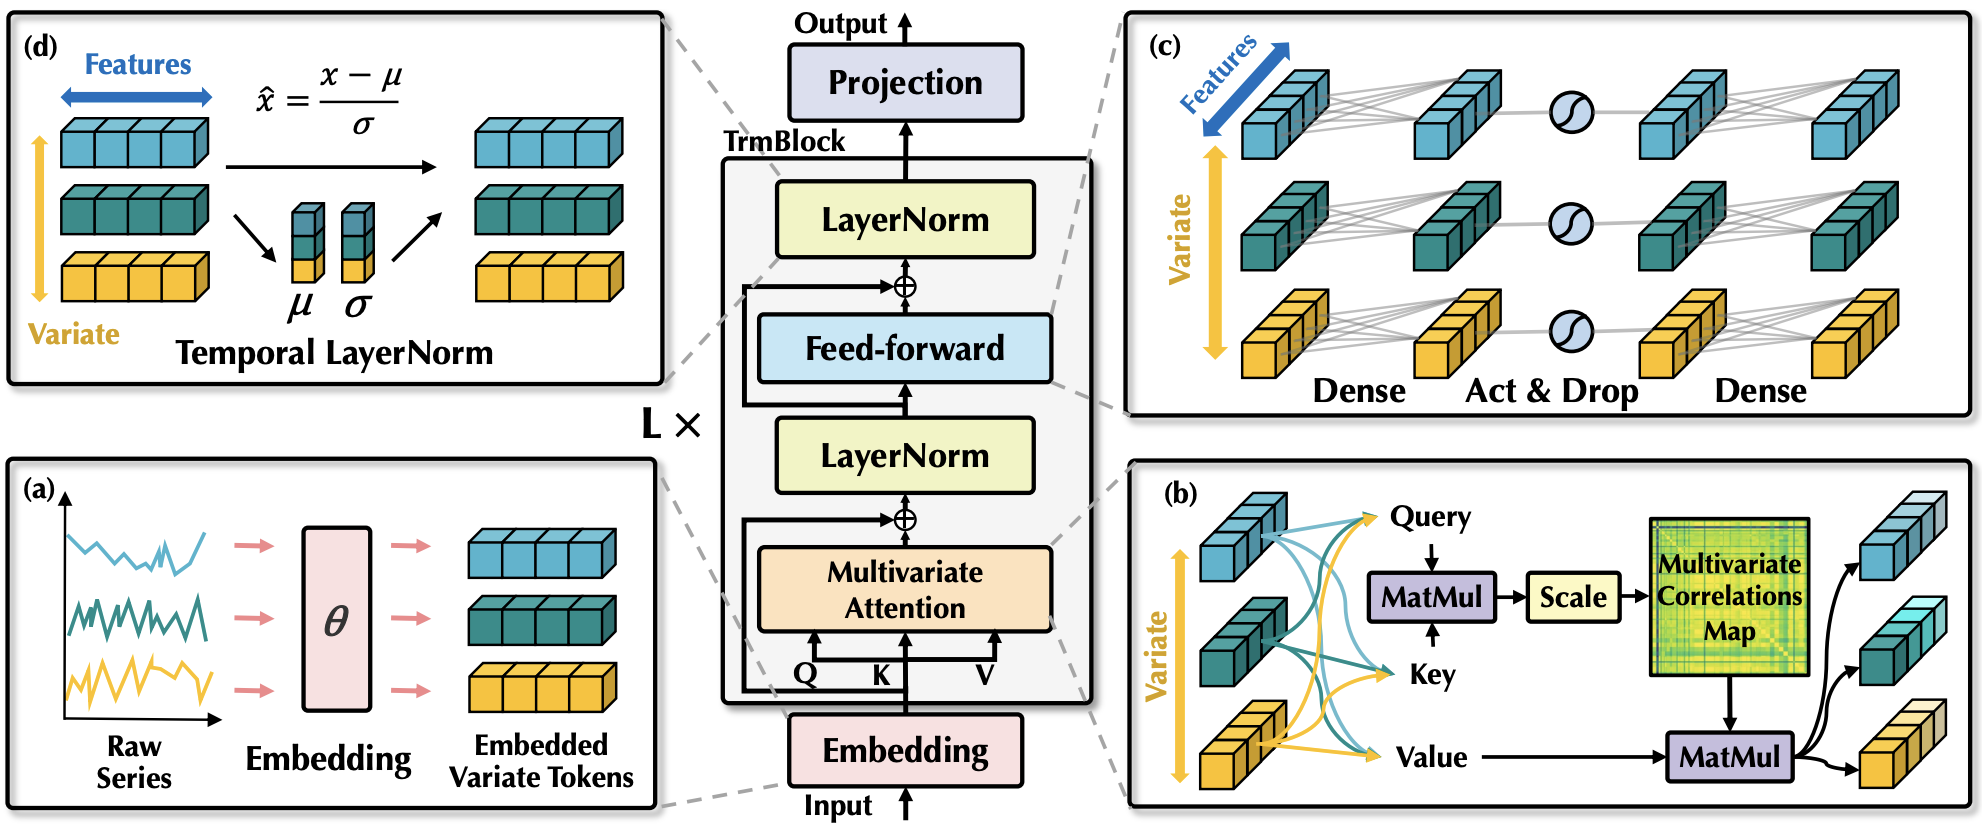

In [13]:
class I_SelfAttentionHead(nn.Module):
    def __init__(self, n_embd,head_size):
        super().__init__()
        self.head_size=head_size

        self.key=nn.Linear(n_embd,n_embd,bias=False)
        self.value=nn.Linear(n_embd,n_embd,bias=False)
        self.query=nn.Linear(n_embd,n_embd,bias=False)

    def forward(self,x,enc_x=None,Mask=False):
        if enc_x is not None:
            key=self.key(enc_x)
            query=self.query(enc_x)
        else:
            key=self.key(x)
            query=self.query(x)


        value=self.value(x)

        attn_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_size ** 0.5)

        seq_length = x.size(1)
        if Mask :
            mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))


        attn_weights = torch.softmax(attn_scores, dim=-1)
        out = torch.matmul(attn_weights, value)
        return out
################################################################################
class I_MultiHeadSelfAttention(nn.Module):

    def __init__(self,num_heads,n_embd,head_size):
        super().__init__()

        self.heads =nn.ModuleList([I_SelfAttentionHead(n_embd, head_size) for _ in range(num_heads)])
        self.projection =nn.Linear(n_embd*num_heads, n_embd)

    def forward(self,x,enc_x=None,Mask=False):

        attn_outputs = [head(x,enc_x,Mask) for head in self.heads]
        # print(attn_outputs)
        combined_attn = torch.cat(attn_outputs, dim=-1)
        out = self.projection(combined_attn)
        return out
################################################################################
class I_FeedForward(nn.Module):

    def __init__(self,n_embd,forward_expansion=4):
        super().__init__()

        self.linear=nn.Sequential(nn.Linear(n_embd,n_embd*forward_expansion), nn.ReLU(), nn.Linear(n_embd*forward_expansion,n_embd))


    def forward(self,x):
        out=self.linear(x)
        return out

In [14]:
class I_EncoderBlock(nn.Module):
    def __init__(self,n_embd,n_head,forward_expansion=4):
        super().__init__()
        self.self_attention =I_MultiHeadSelfAttention(n_head, n_embd, head_size=8)
        self.feed_forward=I_FeedForward(n_embd,forward_expansion)
        self.norm1=nn.LayerNorm(n_embd)
        self.norm2=nn.LayerNorm(n_embd)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):

        atten=self.self_attention(x)
        # print(atten)
        x=self.dropout(self.norm1(x+atten))
        forward=self.feed_forward(x)
        output=self.dropout(self.norm2(forward+x))
        return output
################################################################################
class I_Encoder(nn.Module):
    def __init__(self,vocab_size,block_size,n_head,n_embd,n_layer):
        super().__init__()

        # self.token_embeding=nn.Embedding(vocab_size, n_embd)
        self.position_embeding=nn.Embedding(block_size, n_embd)
        self.blocks =nn.Sequential(*[I_EncoderBlock(n_embd, n_head) for _ in range(n_layer)])
        self.dropout=nn.Dropout(0.3)
        self.conv=nn.Conv1d(9,1,1,1)
    def forward(self,x):

        # token_embeds = self.token_embeding(x)
        seq_length = x.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device)
        position_embeds = self.position_embeding(position_ids)
        # embeddings = token_embeds + position_embeds
        embeddings = x + position_embeds
        # print(embeddings.shape)
        out=self.blocks(embeddings)
        # print(out.shape)
        # out=self.conv(out)
        return out

In [23]:
class iTransformerModel(nn.Module):
    def __init__(self,vocab_size,trg_vocab_size,block_size=10,n_head=8,n_embd=512,n_layer=6 ):
        super(iTransformerModel, self).__init__()

        self.emb=nn.Linear(10,n_embd)
        self.encoder=I_Encoder(vocab_size,block_size,n_head,n_embd,n_layer)
        self.projection=nn.Linear(n_embd,1)

    def forward(self,x):
        #x is the shape of (B,L,N)
        """
        B --> batch size 64
        L --> sequence length 10
        N --> dimention 8
        E --> embeding 512
        S --> output sequence 1
        x(B,L,N) --> x(B,N,E)
        """
        x=self.emb(x.permute(0,2,1))

        enc_out=self.encoder(x)   # B,N,E

        # B,N,E --> B,N,S
        out= self.projection(enc_out)  # B,N,S

        # B,N,S --> B,S,N
        out=out.permute(0,2,1)
        return out





device='cuda' if torch.cuda.is_available() else 'cpu'
src_vocab_size = 4
trg_vocab_size = 1
lr=1e-3
i_model = iTransformerModel(src_vocab_size,trg_vocab_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(i_model.parameters(), lr=lr)

In [30]:


from tqdm.notebook import tqdm
for epoch in range(20):
    running_loss = 0.0
    for batch in tqdm(train_loader,leave=False):

        inputs,targets  = batch
        inputs = inputs.float().to(device)
        targets=targets.float().to(device)

        #target.shape= (64,1,8)
        #inputs = inputs.view(64*8, 10)


        optimizer.zero_grad()


        outputs = i_model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()


        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 1, Loss: 0.04942309119199452


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 2, Loss: 0.04887577260011121


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 3, Loss: 0.048397029504964224


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 4, Loss: 0.04875664844324714


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 5, Loss: 0.047062950973448


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 6, Loss: 0.04678651333639496


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0464402012526989


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 8, Loss: 0.04606442773028424


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0457021216028615


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 10, Loss: 0.045037642513450826


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 11, Loss: 0.044331125287633194


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 12, Loss: 0.04413612579044543


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 13, Loss: 0.04357118661466398


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 14, Loss: 0.043257828958724674


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 15, Loss: 0.04279140335948844


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 16, Loss: 0.04298983651556467


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 17, Loss: 0.042120374229393506


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 18, Loss: 0.04232752362364217


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 19, Loss: 0.04189368294257867


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 20, Loss: 0.041255963868216464


In [31]:

mea=nn.L1Loss()
with torch.no_grad():
    mse_loss=0
    mae_loss=0
    for batch in tqdm(test_loader):
        input,target=batch
        # print(input.shape)
        input ,target=input.float().to(device),target.float().to(device)
        outputs = i_model(input)
        mse_loss+=criterion(outputs,target).item()
        mae_loss+=mea(outputs,target).item()


print(f"On Test data ; MSE: {mse_loss/len(test_loader):.4f} and MAE: {mae_loss/len(test_loader):.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

On Test data ; MSE: 0.0357 and MAE: 0.1509


In ITransformer we have the losses as `On Test data ; MSE: 0.0357 and MAE: 0.1509`

In  Transformer we have the losses as`On Test data ; MSE: 0.2120 and MAE: 0.3684`

which shows that Itransformer prefroms better than Transfomer

